In [1]:
import time

import scipy
import numpy as np
import matplotlib.pyplot as plt

import binstatcuda as bsc

## Random Sample

We sample 10 million points from a 2D Gaussian distribution.

In [2]:
N_SAMPLE = int(1e7)
MU = (-5, 10)
COV = [[10, 5], [5, 10]]

X = np.random.multivariate_normal(mean=MU, cov=COV, size=N_SAMPLE)
X.shape

(10000000, 2)

## Histogram Calculation

With the functions from `binstatcuda` we can effectively,

- visualise the marginal distribution (1D) with `histogram`
- visualise the joint distribution (2D) with `histogram2d`

In [3]:
BIN_EDGE = np.linspace(-25, 25, 101)

bin_centres = (BIN_EDGE[1:] + BIN_EDGE[:-1]) / 2

# warm up
_ = bsc.histogram(X[::10, 0].astype(np.float32), bins=BIN_EDGE)

t0_bsc = time.perf_counter()
hist_bsc_x1 = bsc.histogram(
    X[:, 0].astype(np.float32),  # NOTICE that we have to manually set the datatype to FP32
    bins=BIN_EDGE
)
hist_bsc_x2 = bsc.histogram(
    X[:, 1].astype(np.float32),  # NOTICE that we have to manually set the datatype to FP32
    bins=BIN_EDGE
)
t1_bsc = time.perf_counter()

t0_np = time.perf_counter()
hist_np_x1, _ = np.histogram(
    X[:, 0],
    bins=BIN_EDGE
)
hist_np_x2, _ = np.histogram(
    X[:, 1],
    bins=BIN_EDGE
)
t1_np = time.perf_counter()

print(f"binstatcuda: {(t1_bsc - t0_bsc) * 1000: <8.2f} ms")
print(f"numpy      : {(t1_np - t0_np) * 1000: <8.2f} ms")

binstatcuda: 33.86    ms
numpy      : 170.68   ms


We see the binstatcuda achieves a <font color="tomato">3x</font> speed up.

We can plot the result for both `Numpy` and `binstatdata` to check if they are exactly the same.

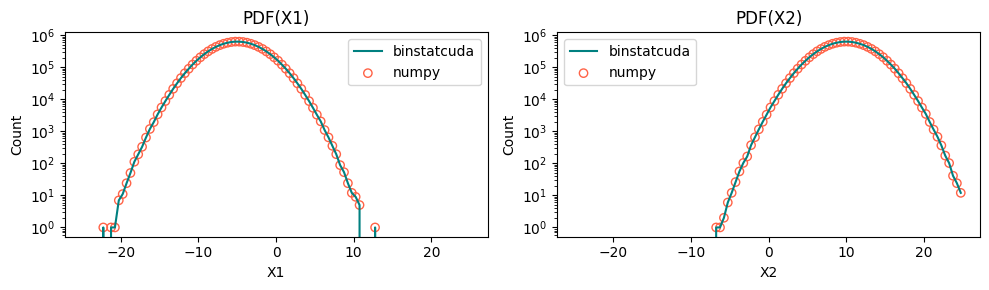

In [4]:
plt.figure(figsize=(10, 3))

plt.subplot(121).plot(bin_centres, hist_bsc_x1, color='teal', label='binstatcuda')
plt.gca().scatter(bin_centres, hist_np_x1, color='tomato', fc='none', label='numpy')
plt.yscale('log')
plt.title("PDF(X1)")
plt.xlabel("X1")
plt.ylabel("Count")
plt.legend()

plt.subplot(122).plot(bin_centres, hist_bsc_x2, color='teal', label='binstatcuda')
plt.gca().scatter(bin_centres, hist_np_x2, color='tomato', fc='none', label='numpy')
plt.yscale('log')
plt.title("PDF(X2)")
plt.xlabel("X2")
plt.ylabel("Count")
plt.legend()

plt.tight_layout()
plt.show()

Now we calculate the joint distribution, and compare between `binstatdata` and `numpy`.

In [5]:
BIN_EDGE = np.linspace(-25, 25, 101)

t0_bsc = time.perf_counter()
hist_bsc_2d = bsc.histogram2d(
    x=X[:, 0].astype(np.float32),  # NOTICE that we have to manually set the datatype to FP32
    y=X[:, 1].astype(np.float32),  # NOTICE that we have to manually set the datatype to FP32
    bins=(BIN_EDGE, BIN_EDGE),
)
t1_bsc = time.perf_counter()

t0_np = time.perf_counter()
hist_np_2d = np.histogram2d(
    x=X[:, 0].astype(np.float32),  # NOTICE that we have to manually set the datatype to FP32
    y=X[:, 1].astype(np.float32),  # NOTICE that we have to manually set the datatype to FP32
    bins=(BIN_EDGE, BIN_EDGE),
)[0]
t1_np = time.perf_counter()

print(f"binstatcuda: {(t1_bsc - t0_bsc) * 1000: <8.2f} ms")
print(f"numpy      : {(t1_np - t0_np) * 1000: <8.2f} ms")

binstatcuda: 34.54    ms
numpy      : 651.28   ms


We see the binstatcuda achieves a <font color="tomato">10x</font> speed up.

We can plot the result for both `Numpy` and `binstatdata` to check if they are exactly the same.

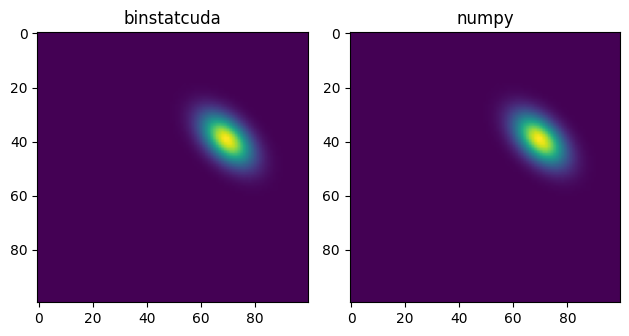

In [6]:
plt.subplot(121).imshow(hist_bsc_2d)
plt.title("binstatcuda")
plt.subplot(122).imshow(hist_np_2d)
plt.title("numpy")
plt.tight_layout()
plt.show()

## Binned Statistics

We sample 10 million points from a 2D Gaussian distribution. And then calculate a value vector from the sampled value.

In [7]:
N_SAMPLE = int(1e7)
MU = (-5, 10)
COV = [[10, 5], [5, 10]]

X = np.random.multivariate_normal(mean=MU, cov=COV, size=N_SAMPLE)
Y = np.sum(X**2 + np.random.uniform(-10, 10, X.shape), axis=1)
X.shape, Y.shape

((10000000, 2), (10000000,))

In [8]:
BIN_EDGE = np.linspace(-20, 20, 101)
bin_centres = (BIN_EDGE[1:] + BIN_EDGE[:-1]) / 2

t0_bsc = time.perf_counter()
mean_bsc = bsc.binned_statistic(
    x=X[:, 0].astype(np.float32),
    values=Y.astype(np.float32),
    bins=BIN_EDGE,
    statistic='mean'
)
std_bsc = bsc.binned_statistic(
    x=X[:, 0].astype(np.float32),
    values=Y.astype(np.float32),
    bins=BIN_EDGE,
    statistic='std'
)
t1_bsc = time.perf_counter()

t0_np = time.perf_counter()
mean_scipy = scipy.stats.binned_statistic(
    x=X[:, 0].astype(np.float32),
    values=Y.astype(np.float32),
    bins=BIN_EDGE,
    statistic='mean'
)[0]

std_scipy = scipy.stats.binned_statistic(
    x=X[:, 0].astype(np.float32),
    values=Y.astype(np.float32),
    bins=BIN_EDGE,
    statistic='std'
)[0]
t1_np = time.perf_counter()

print(f"binstatcuda: {(t1_bsc - t0_bsc) * 1000: <8.2f} ms")
print(f"scipy.stats: {(t1_np - t0_np) * 1000: <8.2f} ms")

binstatcuda: 62.77    ms
scipy.stats: 1180.32  ms


We see the binstatcuda achieves a <font color="tomato">10x</font> speed up.

We can plot the result for both `scipy.stats` and `binstatdata` to check if they are exactly the same.

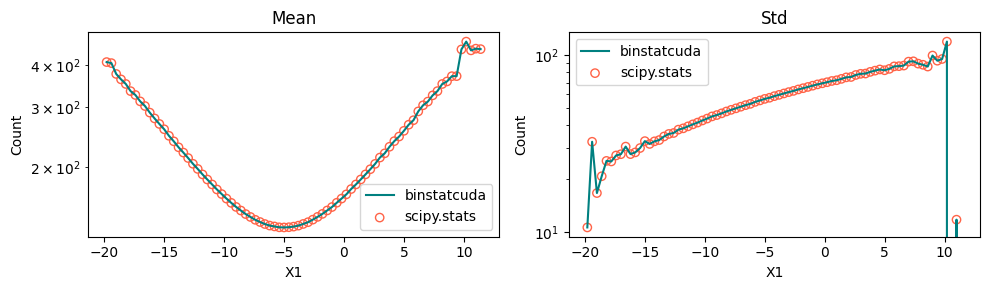

In [9]:
plt.figure(figsize=(10, 3))

plt.subplot(121).plot(bin_centres, mean_bsc, color='teal', label='binstatcuda')
plt.gca().scatter(bin_centres, mean_scipy, color='tomato', fc='none', label='scipy.stats')
plt.yscale('log')
plt.title("Mean")
plt.xlabel("X1")
plt.ylabel("Count")
plt.legend()

plt.subplot(122).plot(bin_centres, std_bsc, color='teal', label='binstatcuda')
plt.gca().scatter(bin_centres, std_scipy, color='tomato', fc='none', label='scipy.stats')
plt.yscale('log')
plt.title("Std")
plt.xlabel("X1")
plt.ylabel("Count")
plt.legend()

plt.tight_layout()
plt.show()

Now we calculate the joint distribution, and compare between `binstatdata` and `scipy.stats`.

In [10]:
BIN_EDGE = np.linspace(-25, 25, 101)

t0_bsc = time.perf_counter()
stat_bsc_2d = bsc.binned_statistic_2d(
    x=X[:, 0].astype(np.float32),  # NOTICE that we have to manually set the datatype to FP32
    y=X[:, 1].astype(np.float32),  # NOTICE that we have to manually set the datatype to FP32
    values=Y.astype(np.float32),
    bins=(BIN_EDGE, BIN_EDGE),
    statistic='mean',
)
t1_bsc = time.perf_counter()

t0_np = time.perf_counter()
stat_scipy_2d = scipy.stats.binned_statistic_2d(
    x=X[:, 0].astype(np.float32),  # NOTICE that we have to manually set the datatype to FP32
    y=X[:, 1].astype(np.float32),  # NOTICE that we have to manually set the datatype to FP32
    values=Y.astype(np.float32),
    bins=(BIN_EDGE, BIN_EDGE),
    statistic='mean',
)[0]
t1_np = time.perf_counter()

print(f"binstatcuda: {(t1_bsc - t0_bsc) * 1000: <8.2f} ms")
print(f"scipy.stats: {(t1_np - t0_np) * 1000: <8.2f} ms")

binstatcuda: 50.89    ms
scipy.stats: 693.13   ms


We see the binstatcuda achieves a <font color="tomato">10x</font> speed up.

We can plot the result for both `scipy.stats` and `binstatdata` to check if they are exactly the same.

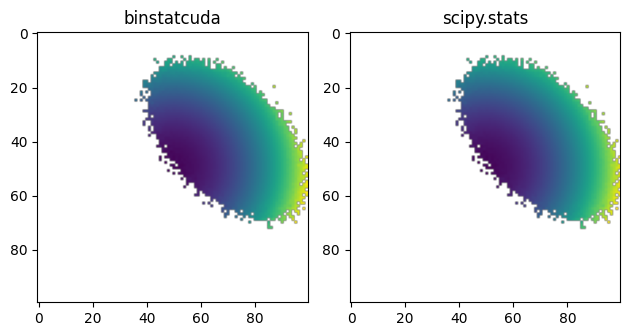

In [11]:
plt.subplot(121).imshow(stat_bsc_2d)
plt.title("binstatcuda")
plt.subplot(122).imshow(stat_scipy_2d)
plt.title("scipy.stats")
plt.tight_layout()
plt.show()